In [2]:
import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv('datafinal.csv', sep=';')

In [4]:
df.drop(df.columns[[1]], axis=1, inplace=True)

In [5]:
df['clasificacion'] = df['punt_global'].apply(lambda x: 1 if x > 320 else 0)

In [6]:
df_1=df[df['clasificacion']==1]
df_0=df[df['clasificacion']==0]

In [7]:
#Filas para la muestra que sean las que tienen 1
n_1=len(df_1)
#Muestrear ese numero de filas con clasificación = 0
df_0_sample =df_0.sample(n=n_1, random_state=42)
#Combinar los subconjuntos
df_balanced =pd.concat([df_1,df_0_sample])
#Mezclar ell dataframe resultante
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['clasificacion'].value_counts())
df_balanced.head()

clasificacion
1    16962
0    16962
Name: count, dtype: int64


,periodo,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_dane_establecimiento,cole_cod_dane_sede,cole_cod_depto_ubicacion,cole_cod_mcpio_ubicacion,...,fami_tieneinternet,fami_tienelavadora,desemp_ingles,punt_ingles,punt_matematicas,punt_sociales_ciudadanas,punt_c_naturales,punt_lectura_critica,punt_global,clasificacion
0,20191,SB11201910028535,URBANO,N,B,ACADÉMICO,3.760000e+11,3.760000e+11,76,76001,...,Si,Si,B+,80,62,65,67,71,337,1
1,20194,SB11201940529895,URBANO,N,A,ACADÉMICO,1.760000e+11,1.760000e+11,76,76041,...,Si,No,A-,41,31,33,34,29,162,0
2,20194,SB11201940295505,URBANO,N,A,TÉCNICO/ACADÉMICO,3.760000e+11,3.760000e+11,76,76001,...,Si,Si,A1,49,53,55,53,43,254,0
3,20194,SB11201940085160,URBANO,N,A,TÉCNICO/ACADÉMICO,1.760000e+11,1.760000e+11,76,76001,...,Si,Si,A-,40,48,52,51,53,251,0
4,20224,SB11202240101999,URBANO,N,A,TÉCNICO/ACADÉMICO,1.770000e+11,1.770000e+11,76,76520,...,Si,Si,A-,38,59,50,40,46,240,0


In [8]:
X = df_balanced[['fami_tienecomputador','cole_bilingue','cole_area_ubicacion','estu_genero','fami_estratovivienda',
        'cole_naturaleza','fami_tieneinternet','fami_educacionpadre','fami_educacionmadre']]
y = df_balanced["clasificacion"]

In [9]:
X

,fami_tienecomputador,cole_bilingue,cole_area_ubicacion,estu_genero,fami_estratovivienda,cole_naturaleza,fami_tieneinternet,fami_educacionpadre,fami_educacionmadre
0,Si,N,URBANO,F,Estrato 4,NO OFICIAL,Si,Educación profesional completa,Educación profesional completa
1,Si,N,URBANO,F,Estrato 2,OFICIAL,Si,Ninguno,Primaria incompleta
2,Si,N,URBANO,F,Estrato 2,NO OFICIAL,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa
3,Si,N,URBANO,F,Estrato 2,OFICIAL,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa
4,No,N,URBANO,M,Estrato 1,OFICIAL,Si,Primaria incompleta,Secundaria (Bachillerato) completa
...,...,...,...,...,...,...,...,...,...
33919,No,N,URBANO,F,Estrato 1,OFICIAL,Si,Primaria completa,Primaria incompleta
33920,Si,N,URBANO,M,Estrato 2,OFICIAL,Si,No sabe,Educación profesional completa
33921,Si,S,RURAL,M,Estrato 6,NO OFICIAL,Si,Postgrado,Postgrado
33922,Si,N,URBANO,M,Estrato 3,OFICIAL,No,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa


In [10]:
y

0        1
1        0
2        0
3        0
4        0
        ..
33919    1
33920    1
33921    1
33922    1
33923    1
Name: clasificacion, Length: 33924, dtype: int64

## Entrenamiento de Datos

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42)

In [12]:
categorical_features = ['fami_tienecomputador','cole_bilingue','cole_area_ubicacion',
                        'estu_genero','fami_estratovivienda','cole_naturaleza',
                        'fami_tieneinternet','fami_educacionpadre','fami_educacionmadre']

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Crear un pipeline que incluya el preprocesamiento y el modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [15]:
pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['fami_tienecomputador',
                                                   'cole_bilingue',
                                                   'cole_area_ubicacion',
                                                   'estu_genero',
                                                   'fami_estratovivienda',
                                                   'cole_naturaleza',
                                                   'fami_tieneinternet',
                                                   'fami_educacionpadre',
                                                   'fami_educacionmadre'])]))])

In [16]:
X_train_preprocessed = pipeline.transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

In [22]:
input_dim = X_test_preprocessed.shape[1]

model = Sequential([
    Dense(60, input_dim=input_dim, activation='relu'),
    Dense(60, activation='relu'),
    Dense(40, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [23]:
def specificity(y_true, y_pred):
    tn = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * (1 - y_pred), 'float32'))
    fp = tf.keras.backend.sum(tf.keras.backend.cast((1 - y_true) * y_pred, 'float32'))
    return tn / (tn + fp + tf.keras.backend.epsilon())

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), specificity, 'binary_crossentropy'])

In [25]:
print(X_train_preprocessed.shape[1])

43


In [26]:
history = model.fit(X_train_preprocessed, y_train, epochs=50,
                    validation_data=(X_test_preprocessed, y_test))

Epoch 1/50


849/849 [==============================] - 9s 4ms/step - loss: 0.5759 - accuracy: 0.6917 - precision_1: 0.6985 - recall_1: 0.6724 - specificity: 0.6050 - binary_crossentropy: 0.5759 - val_loss: 0.5781 - val_accuracy: 0.6931 - val_precision_1: 0.7193 - val_recall_1: 0.6415 - val_specificity: 0.6240 - val_binary_crossentropy: 0.5781
Epoch 2/50
849/849 [==============================] - 3s 3ms/step - loss: 0.5606 - accuracy: 0.7042 - precision_1: 0.7092 - recall_1: 0.6901 - specificity: 0.6173 - binary_crossentropy: 0.5606 - val_loss: 0.5753 - val_accuracy: 0.6971 - val_precision_1: 0.6962 - val_recall_1: 0.7082 - val_specificity: 0.6165 - val_binary_crossentropy: 0.5753
Epoch 3/50
849/849 [==============================] - 3s 4ms/step - loss: 0.5568 - accuracy: 0.7077 - precision_1: 0.7109 - recall_1: 0.6981 - specificity: 0.6219 - binary_crossentropy: 0.5568 - val_loss: 0.5764 - val_accuracy: 0.6927 - val_precision_1: 0.7031 - val_recall_1: 0.6757 - val_specificity: 0.6061 

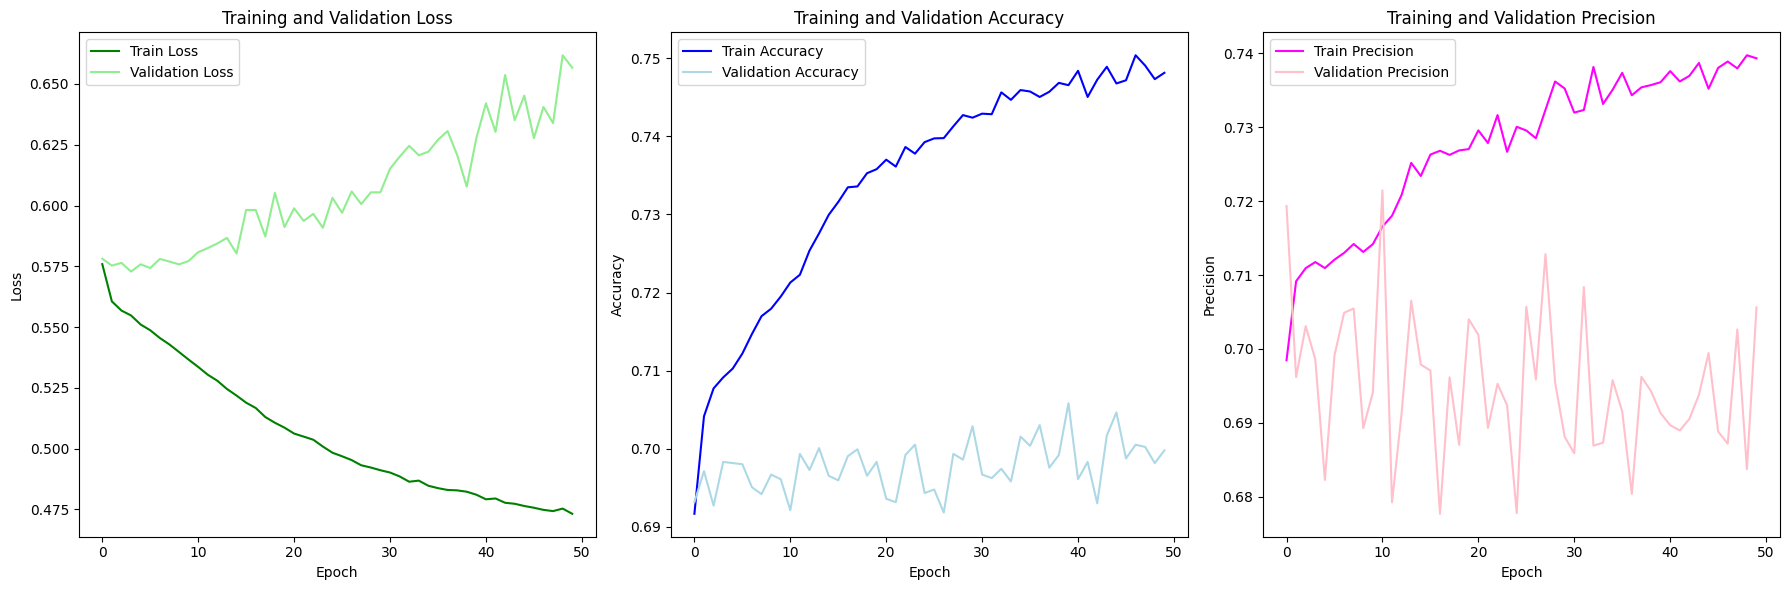

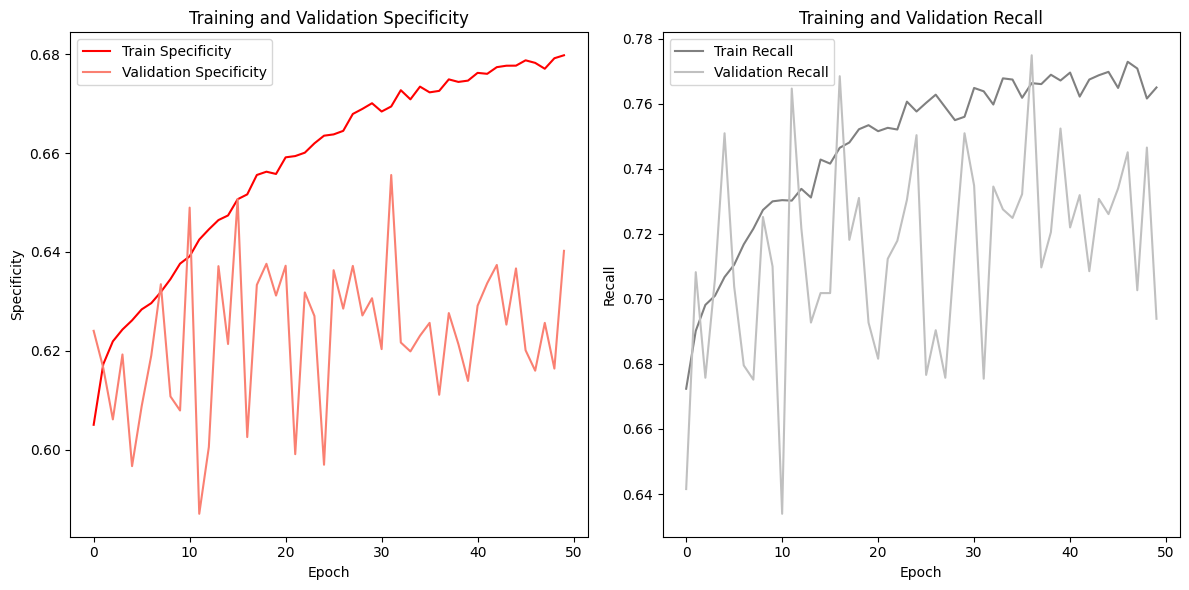

In [28]:
import matplotlib.pyplot as plt

# Obtener la pérdida y la precisión del entrenamiento y la validación desde history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

specificity = history.history['specificity']
val_specificity = history.history['val_specificity']

recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

precision = history.history['precision_1']
val_precision = history.history['val_precision_1']


# Crear gráficos
plt.figure(figsize=(18, 6))

# Gráfico de pérdida
plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Train Loss', color='green')
plt.plot(val_loss, label='Validation Loss', color='lightgreen')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de accuracy
plt.subplot(1, 3, 2)
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='lightblue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Grafico de precisión
plt.subplot(1, 3, 3)
plt.plot(precision, label='Train Precision', color='Magenta')
plt.plot(val_precision, label='Validation Precision', color='pink')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()


plt.tight_layout()
plt.show()

# Crear gráficos
plt.figure(figsize=(12, 6))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(specificity, label='Train Specificity', color='red')
plt.plot(val_specificity, label='Validation Specificity', color='Salmon')
plt.title('Training and Validation Specificity')
plt.xlabel('Epoch')
plt.ylabel('Specificity')
plt.legend()

# Gráfico de accuracy
plt.subplot(1, 2, 2)
plt.plot(recall, label='Train Recall', color='Gray')
plt.plot(val_recall, label='Validation Recall', color='Silver')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()


plt.tight_layout()
plt.show()



In [29]:
import numpy as np
import pandas as pd

# Nuevos datos en un DataFrame
new_data = pd.DataFrame({
    'fami_tienecomputador': ['No'],
    'cole_bilingue': ['N'],
    'cole_area_ubicacion': ['URBANO'],
    'estu_genero': ['M'],
    'fami_estratovivienda': ['Estrato 2'],
    'cole_naturaleza': ['NO OFICIAL'],
    'fami_tieneinternet': ['No'],
    'fami_educacionpadre': ['Primaria Incompleta'],
    'fami_educacionmadre': ['Secundaria (Bachillerato) completa'],
})


# Asegúrate de que el pipeline esté ajustado
pipeline.fit(X_train, y_train)  # Ajustar el pipeline con los datos de entrenamiento

# Preprocesar los datos nuevos
new_data_preprocessed = pipeline.transform(new_data)

# Hacer predicciones con el modelo
predictions = model.predict(new_data_preprocessed)

# Un umbral para la predicción
umbral = 0.7

# Obtener la probabilidad
predicted_probability = predictions[0, 0]  

# Aplicar el umbral para obtener la predicción binaria
binary_prediction = 1 if predicted_probability > umbral else 0

# Mostrar la predicción binaria
print("Predicción:", binary_prediction)


1/1 [==============================] - 0s 326ms/step
Predicción: 0


In [32]:

new_data2 = pd.DataFrame({
    'fami_tienecomputador': ['Si'],
    'cole_bilingue': ['N'],
    'cole_area_ubicacion': ['URBANO'],
    'estu_genero': ['F'],
    'fami_estratovivienda': ['Estrato 4'],
    'cole_naturaleza': ['NO OFICIAL'],
    'fami_tieneinternet': ['Si'],
    'fami_educacionpadre': ['Educación profesional completa'],
    'fami_educacionmadre': ['Educación profesional completa'],
})


# Asegúrate de que el pipeline esté ajustado
pipeline.fit(X_train, y_train)  # Ajustar el pipeline con los datos de entrenamiento

# Preprocesar los datos nuevos
new_data_preprocessed2 = pipeline.transform(new_data2)

# Hacer predicciones con el modelo
predictions2 = model.predict(new_data_preprocessed2)

# Un umbral para la predicción
umbral = 0.7

# Obtener la probabilidad
predicted_probability = predictions2[0, 0]  

# Aplicar el umbral para obtener la predicción binaria
binary_prediction = 1 if predicted_probability > umbral else 0

# Mostrar la predicción binaria
print("Predicción:", binary_prediction)


1/1 [==============================] - 0s 31ms/step
Predicción: 1
